<a href="https://colab.research.google.com/github/RLWH/reinforcement-learning-notebook/blob/master/6.%20Policy%20Gradient/Solving_Cartpole_by_A2C_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving Cartpole by A2C Algorithm

In [2]:
#@title Wrapper function for openai gym rendering
import gym
import matplotlib
import matplotlib.pyplot as plt
import glob
import io
import base64
import numpy as np

from gym import logger as gymlogger
from gym.wrappers import Monitor

%matplotlib inline


## Setup the environment

In [3]:
env = gym.make("CartPole-v0")

In [4]:
print("Observation space: %s" % env.observation_space.shape[0])
print("Action space: %s" % env.action_space.n)

Observation space: 4
Action space: 2


In [5]:
GLOBAL_STEP = env.env.spec.max_episode_steps
SCORE_REQUIREMENT = -198
NUM_EPISODES = 10000

In [6]:
GLOBAL_STEP

200

## Setup the network

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import deque
from torch.distributions import Categorical

In [8]:
class PolicyNetwork(nn.Module):
    """
    Policy Network -> Update the policy gradient
    """
    
    def __init__(self, state_size, action_size, fc1_units=16):
        super().__init__()
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, action_size)
        self.logsoftmax = nn.LogSoftmax(dim=0)
#         self.fc3 = nn.Linear(fc2_units, action_size)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        """
        Forward pass
        Essentially, the forward pass return the Q value
        """
        x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
        x = F.softmax(self.fc2(x), dim=-1)
        
        return x

In [9]:
class ValueNetwork(nn.Module):
    """
    Policy Network
    """
    
    def __init__(self, state_size, fc1_units=16):
        super().__init__()
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, 1)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        """
        Forward pass
        Essentially, the forward pass return the Q value
        """
        x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

In [10]:
# Check GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Algorithm
---
```
Input: a differentiable policy parameterization pi(a|s, theta)                   [Policy Network]
Input: a differentiable state-value function parameterization Q_w(s, a, w)       [Value Network]
Parameters: step sizes alpha_theta > 0; alpha_w > 0
​
Loop forever for each episode:
​
        Initialise S, theta
        Sample a from policy network
        
        Loop while S is not terminal for each time step:
                A = pi(.|S, theta) [policy(state)]
                Take action A, observe S', R
                delta = R + gamma * A(S', A', w) - A(S, A, w)  [TD(0) error, or advantage]
                theta = theta + alpha_theta * grad_pi log pi_theta(s,a) A(S,A)     [policy gradient update]
                w = w + alpha_w * delta * x(s, a)    [TD(0)]
                A = A', S = S'
```
---

In [11]:
class A2CAgent:
    """Actor Critic Agent"""
    
    def __init__(self, n_state, n_action, policy_network):
        
        self.env = env
        
        self.n_state = n_state
        self.n_action = n_action
        
        # Initialise the model
        self.policy_network = policy_network
    
    def act(self, state):
#         state = state.float()
        probs = self.policy_network(state)
#         value = self.value_network(Variable(state))
        m = Categorical(probs)
        action = m.sample()
        log_probs = m.log_prob(action)
        entropy = m.entropy()
#         policy.saved_log_probs.append(log_prob)

        return log_probs, action.item(), entropy

## TD(0) Algorithm

In [91]:
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

policy_network = PolicyNetwork(observation_space, action_space, fc1_units=128)
value_network = ValueNetwork(observation_space, fc1_units=128)

# critic_optimizer = torch.optim.Adam(value_network.parameters(), lr=3e-4)
# actor_optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-4)

optimizer = torch.optim.Adam(list(value_network.parameters()) + list(policy_network.parameters()), lr=5e-5)

agent = A2CAgent(observation_space, action_space, policy_network)

reward_list = deque(maxlen=100)
ep_losses = []

for i in range(10000 + 1):
    
    # Log the results
    action_log_probs = []
    rewards = []
    states = []
    targets = []
    errors = []
    t = 0
    R = 0
    
    state = torch.FloatTensor(env.reset())
    
    while True:
        
        # Select and take action
        log_probs, action, entropy = agent.act(state)
        
        # Sample R_t+1 and S_t+1
        next_state, reward, done, _ = env.step(action)
        
        next_state = torch.FloatTensor(next_state)
        
        # Find the value of the next step
        next_state_value = value_network(next_state)
        current_state_value = value_network(state)
        
        td_target = reward + 0.99 * next_state_value * (1 - done)
        
        # TD loss, or advantage
        advantage = td_target - current_state_value.item()
        value_loss = (advantage) ** 2
        actor_loss = -(log_probs * advantage.detach())
        
        total_loss = 0.5 * value_loss + actor_loss
        
        # Optimize
        optimizer.zero_grad()
        
        total_loss.backward()
        
        optimizer.step()
        
        R += reward
        
        if done:
            reward_list.append(R)
            ep_losses.append(total_loss)
            break
            
        # Update state
        state = next_state
        
    if i % 1000 == 0:
        print("\rEpisode %s \t Average Score: %s" % (i, np.mean(reward_list)))

Episode 0 	 Average Score: 51.0


KeyboardInterrupt: 

## TD(0) Algorithm - Alternative
https://www.datahubbs.com/policy-gradients-and-advantage-actor-critic/

In [110]:
# https://www.datahubbs.com/policy-gradients-and-advantage-actor-critic/

ep_rewards = []

policy_network = PolicyNetwork(observation_space, action_space, fc1_units=128)
value_network = ValueNetwork(observation_space, fc1_units=128)

optimizer = torch.optim.Adam(list(value_network.parameters()) + list(policy_network.parameters()), lr=5e-5)

agent = A2CAgent(observation_space, action_space, policy_network)

for ep in range(2000 + 1):
    
    state = torch.FloatTensor(env.reset())
    
    actions = []
    rewards = []
    states = []
    targets = []
    errors = []
    
    t = 0
    
    for i in range(GLOBAL_STEP):
        
        # Select and take action
        log_probs, action, entropy = agent.act(state)
        next_step, reward, done, _ = env.step(action)
        
        # Calculate predictions and error
        current_state_value = value_network(state)
        next_state_value = value_network(next_state)
        
        target = reward + 0.9 * next_state_value * (1 - done)
        error = target - current_state_value.detach()
        
        # Log results
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        targets.append(target)
        errors.append(error)
        
        value_loss = error ** 2
        actor_loss = -log_probs * error.detach()
        
        total_loss = value_loss + actor_loss
        
        # Optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        state = next_state
        
        if done:
            ep_rewards.append(np.sum(rewards))
            break
            
    # Print average of last 10 episodes if true
    if ep % 100 == 0 and ep != 0:
        avg_rewards = np.mean(ep_rewards[:-100])
        print("\rOne-step A2C at Episode: {:d}, Avg Reward: {:.2f}".format(ep, avg_rewards), end="")

One-step A2C at Episode: 2000, Avg Reward: 19.69

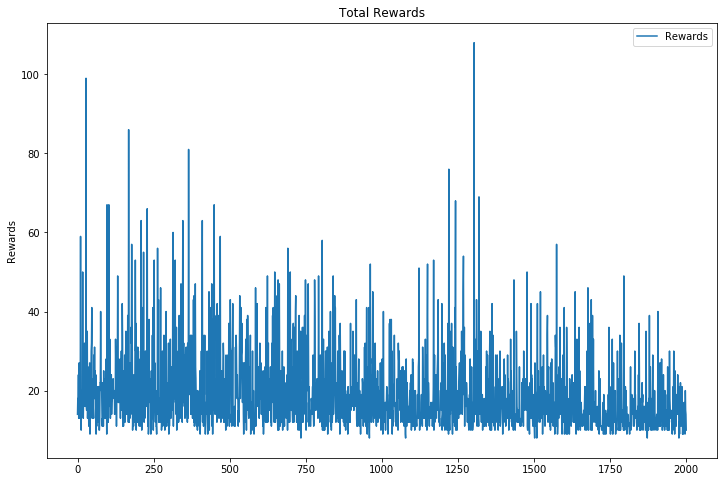

In [111]:
# Plot results 
plt.figure(figsize=(12,8))
plt.plot(ep_rewards, label='Rewards')
# plt.plot(rewards_smooth, label='Smoothed Rewards')
plt.title('Total Rewards')
plt.legend(loc='best')
plt.ylabel('Rewards')
plt.show()

## From one step to n-step - TD(n) Algorithm

In [12]:
from collections import namedtuple

In [13]:
Experience = namedtuple("Experience", ["state", "log_probs", "actions", "rewards", "dones", "next_states"])

In [14]:
def calculate_rewards(rewards, gamma=0.9):
    
    G = 0
    
    for r in reversed(rewards):
        G += gamma * r
    
    return G

In [79]:
def run_once(n_step):
    """
    Run once
    """

    ep_rewards = []

    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n

    policy_network = PolicyNetwork(observation_space, action_space, fc1_units=128)
    value_network = ValueNetwork(observation_space, fc1_units=128)

    optimizer = torch.optim.Adam(list(value_network.parameters()) + list(policy_network.parameters()), lr=8e-4)

    agent = A2CAgent(observation_space, action_space, policy_network)

    for ep in range(5000 + 1):

        state = torch.FloatTensor(env.reset())

        experiences = []
        R = 0

        for i in range(GLOBAL_STEP):

            """
            Just generating the episodes here
            """

            # For the first n steps, only generate and save the experience
            log_prob, action, entropy = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = torch.FloatTensor(next_state)

            exp = Experience(state, log_prob, action, reward, next_state, done)
            experiences.append(exp)

            state = next_state

            R += reward

            if done:
                experiences.append(exp)
                ep_rewards.append(R)
                break

        # Then we do the learning here
        states, log_probs, actions, rewards, next_states, dones = zip(*experiences)

        # 1. Calculate the discounted rewards
        Gs = []
        for i in range(len(rewards) - n_step):
            Gs.append(calculate_rewards(rewards[i:i + n_step]))

        value_losses = []
        actor_losses = []
        
        n_step = min(n_step, len(states))

        for i in range(len(states) - n_step):

            current_state_value = value_network(states[i])
            next_state_value = value_network(next_states[i])

            target = Gs[i] + 0.99 * next_state_value * (1 - dones[i])
            error = target - current_state_value.detach()

            value_loss = error ** 2
            actor_loss = -log_probs[i] * error.detach()

            value_losses.append(value_loss)
            actor_losses.append(actor_loss)

        # Optimize
        optimizer.zero_grad()
        total_loss = torch.stack(value_losses).sum() + torch.stack(actor_losses).sum()

        total_loss.backward()
        optimizer.step()

        # Print average of last 10 episodes if true
        if ep % 100 == 0 and ep != 0:
            avg_rewards = np.mean(ep_rewards[:-100])
            print("\r{:d}-step A2C at Episode: {:d}, Avg Reward: {:.2f}".format(n_step, ep, avg_rewards), end="")
    
    print(".....End Run")
    
    return ep_rewards

In [80]:
n_step_list = list(range(5, 20, 2))

In [81]:
rewards_list = []

In [ ]:
for i in n_step_list:
    
    reward = run_once(n_step=i)
    rewards_list.append(reward)
    

5-step A2C at Episode: 5000, Avg Reward: 158.26.....End Run
7-step A2C at Episode: 5000, Avg Reward: 150.05.....End Run
9-step A2C at Episode: 4400, Avg Reward: 151.94

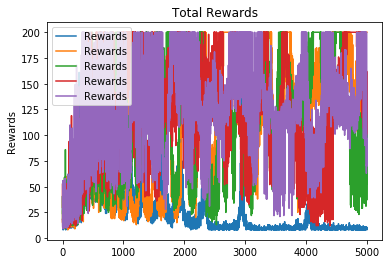

In [54]:
# Plot results 
fig, ax = plt.subplots()
for r in rewards_list:
    ax.plot(r, label='Rewards')
    # plt.plot(rewards_smooth, label='Smoothed Rewards')
plt.title('Total Rewards')
plt.legend(loc='best')
plt.ylabel('Rewards')
plt.show()